In [61]:
## Load Data

## Load Data

In [4]:
# Download data with yfinance google stock
data = yf.download('GOOG', 
                   start='2014-1-1',
                   end='2024-12-1',
                   progress=False)
df = data[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df = df.droplevel(1, axis=1)
df.head()

Price,Adj Close,Open,Close,High,Low
Date,,,,,
2014-01-02,27.625,27.782,27.724,27.839,27.603
2014-01-03,27.423,27.771,27.522,27.819,27.520
2014-01-06,27.729,27.721,27.829,27.867,27.558
2014-01-07,28.264,28.020,28.365,28.386,27.924
2014-01-08,28.322,28.543,28.424,28.576,28.226


In [5]:
df.count()

Price
Adj Close    2747
Open         2747
Close        2747
High         2747
Low          2747
dtype: int64

### split data for training

In [6]:
train_len = int(len(df)*0.8) # split data with pecentage
train_df = df[:train_len].Close.values.reshape(-1, 1)
test_df = df[train_len:].Close.values.reshape(-1, 1)

In [7]:
# tr_data is function split data with steps for X and y and use minmaxscaler as normalizer
def tr_data(df, X_steps=10, y_steps=3):
    train_len = int(len(df)*0.8)# split data with pecentage
    train_df = df[:train_len].Close.values.reshape(-1, 1) # use close and change data to one column for traing
    test_df = df[train_len-X_steps:].Close.values.reshape(-1, 1) # use close and change data to one column for testing
    # use MinMaxScaler as normalizer for our data
    sc = MinMaxScaler(feature_range=(0,1))
    train_df_s = sc.fit_transform(train_df) 
    
    X_train = [] # a list to append X train data with X_steps
    y_train = [] # a list to append y train data with y_steps

    """
    a range loop to start at X_steps and end with subtraction of y_steps
    and the plus one is for don't remove the last one
    """
    for i in range(X_steps, len(train_df_s)-y_steps+1): 
        X_train.append(train_df_s[i-X_steps:i]) 
        y_train.append(train_df_s[i:i+y_steps])
    
    X_train = np.array(X_train) # return the list to numpy array
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #change the array to a new shape like (-1, 1)
    y_train = np.array(y_train)
    
    
    test_df_s = sc.transform(test_df)
   
    X_test = [] # a list to append X test data with X_steps
    y_test = [] # a list to append y test data with X_steps
    
    """
    a range loop to start at X_steps and end with subtraction of y_steps
    and the plus one is for don't remove the last one
    """
    for i in range(X_steps, len(test_df_s)-y_steps+1):
        X_test.append(test_df_s[i-X_steps:i])
        y_test.append(test_df_s[i:i+y_steps])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = np.array(y_test)
    # return the sc is for undo the normalization transfrom 
    return X_train, X_test, y_train, y_test, sc 
        
    


In [8]:
#split data
X_train, X_test, y_train, y_test, sc = tr_data(df, 10, 3)

In [9]:
#print data shapes 
print('X_train size: ',X_train.shape, 
      '\nX_test size: ',X_test.shape, 
      '\ny_train size: ',y_train.shape, 
      '\ny_test size: ', y_test.shape,)

X_train size:  (2185, 10, 1) 
X_test size:  (548, 10, 1) 
y_train size:  (2185, 3, 1) 
y_test size:  (548, 3, 1)


In [10]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 239.6 kB/s eta 0:00:00a 0:00:01


## Model

### Use keras_tuner 

In [18]:
import keras_tuner as kt
## Use keras_tuner to help find better model structers
#the build model is our function to do our random search
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_1', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_2', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_3', min_value=50, max_value=200, step=50)))
    model.add(keras.layers.Dense(units=hp.Int('layer_4', min_value=50, max_value=200, step=50), activation='relu'))
    model.add(keras.layers.Dense(3))
    
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])
    return model

In [19]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_4 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}


In [21]:
# search on our build_model
tuner.search(X_train, y_train, validation_split=0.2, epochs=20)

Trial 3 Complete [00h 02m 13s]
loss: 0.0073999164160341024

Best loss So Far: 0.007365272846072912
Total elapsed time: 00h 05m 01s


In [22]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/naeimz/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 100)        │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,303 (384.00 KB)

 Trainable params: 98,303 (384.00 KB)

 Non-trainable params: 0 (0.00 B)

### fit our best model RNN

In [23]:
history_rnn = best_model.fit(X_train, y_train, epochs=100,  validation_split=0.2)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0282 - mse: 0.0020 - val_loss: 0.0497 - val_mse: 0.0038
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0099 - mse: 2.0135e-04 - val_loss: 0.0470 - val_mse: 0.0032
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0082 - mse: 1.5002e-04 - val_loss: 0.0596 - val_mse: 0.0049
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0079 - mse: 1.3742e-04 - val_loss: 0.0301 - val_mse: 0.0014
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0073 - mse: 1.1074e-04 - val_loss: 0.0546 - val_mse: 0.0041
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0075 - mse: 1.2305e-04 - val_loss: 0.0637 - val_mse: 0.0054
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0089 - mse: 1.6239e-04 - val_loss: 0.0626 - val_mse: 0.0051
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0074 - mse: 1.2008e-04 - val_loss: 0.0635 - val_mse: 0.0051
Epoch 9/100
55/55 ━━━━━━━━━

In [24]:
rnn_pred = best_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [25]:
best_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0512 - mse: 0.0050


[0.08920105546712875, 0.012228178791701794]

In [42]:
#To Plot our prediction with real data
def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")

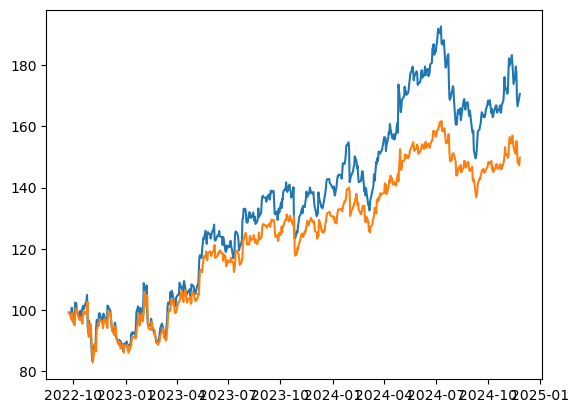

In [43]:
prediction_plot(rnn_pred)

## LSTM Model

In [31]:
#LSTM model with same architecture of Rnn best model
lstm = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(200),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(3)
])

In [35]:
lstm.compile(optimizer='adam', loss='mae', metrics=['mse'])

### Fit model

In [37]:
lstm_history = lstm.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0162 - mse: 5.5056e-04 - val_loss: 0.0362 - val_mse: 0.0022
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0146 - mse: 4.2481e-04 - val_loss: 0.0591 - val_mse: 0.0049
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0135 - mse: 3.4415e-04 - val_loss: 0.0668 - val_mse: 0.0061
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0112 - mse: 2.7393e-04 - val_loss: 0.0503 - val_mse: 0.0036
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0118 - mse: 2.8317e-04 - val_loss: 0.0338 - val_mse: 0.0016
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0111 - mse: 2.5742e-04 - val_loss: 0.0351 - val_mse: 0.0018
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.0101 - mse: 2.2058e-04 - val_loss: 0.0331 - val_mse: 0.0016
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0121 - mse: 2.8708e-04 - val_loss: 0.0544 - val_mse: 0.0040
Epoch 9/100
55

In [38]:
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,011 (3.80 MB)

 Trainable params: 332,003 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 664,008 (2.53 MB)

In [39]:
# Use for plot our predict
lstm_pred = lstm.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


In [40]:
lstm.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0255 - mse: 0.0011  


[0.0336090587079525, 0.0017989402404055]

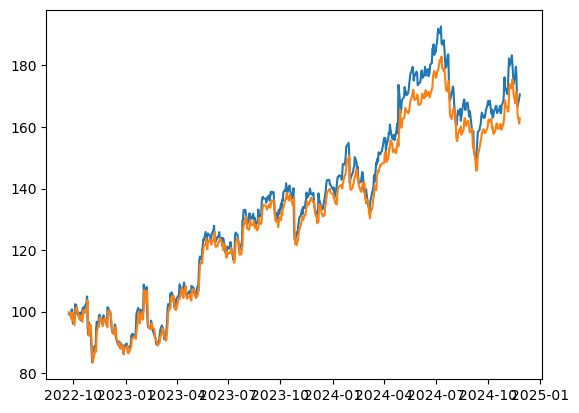

In [ ]:
# plot our lstm model
prediction_plot(lstm_pred)

## GRU Model

In [48]:
gru_model = keras.models.Sequential([
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.GRU(200),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(3)
])

In [49]:
gru_model.compile(optimizer='adam', loss='mae', metrics=['mse'])

### Fit model

In [51]:
gru_history = gru_model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.0718 - mse: 0.0144 - val_loss: 0.0291 - val_mse: 0.0013
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0104 - mse: 2.2311e-04 - val_loss: 0.0488 - val_mse: 0.0032
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0120 - mse: 2.8058e-04 - val_loss: 0.0361 - val_mse: 0.0019
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0100 - mse: 2.0560e-04 - val_loss: 0.0315 - val_mse: 0.0015
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0100 - mse: 1.9750e-04 - val_loss: 0.0277 - val_mse: 0.0012
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0101 - mse: 2.1217e-04 - val_loss: 0.0370 - val_mse: 0.0020
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0092 - mse: 1.7523e-04 - val_loss: 0.0224 - val_mse: 8.4816e-04
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0095 - mse: 1.7738e-04 - val_loss: 0.0302 - val_mse: 0.0014
Epoch 9/100
5

In [52]:
# use for plot our prediction
gru_pred = gru_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


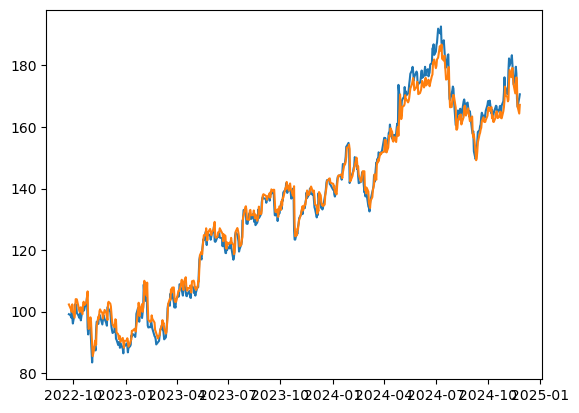

In [53]:
#plot our predtion
prediction_plot(gru_pred)

### Model with GRU and LSTM layers

In [65]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(3)
])

In [66]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

### Fit Model

In [67]:
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - loss: 0.0808 - mse: 0.0156 - val_loss: 0.0381 - val_mse: 0.0022
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0132 - mse: 3.4797e-04 - val_loss: 0.0543 - val_mse: 0.0041
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 0.0132 - mse: 3.3028e-04 - val_loss: 0.0681 - val_mse: 0.0061
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0113 - mse: 2.6188e-04 - val_loss: 0.0326 - val_mse: 0.0016
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0121 - mse: 3.1287e-04 - val_loss: 0.0341 - val_mse: 0.0019
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0128 - mse: 3.3144e-04 - val_loss: 0.0338 - val_mse: 0.0018
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0134 - mse: 3.5946e-04 - val_loss: 0.0335 - val_mse: 0.0016
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0121 - mse: 2.9809e-04 - val_loss: 0.0361 - val_mse: 0.0019
Epoch 9/100
55/55

In [68]:
model_pred = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


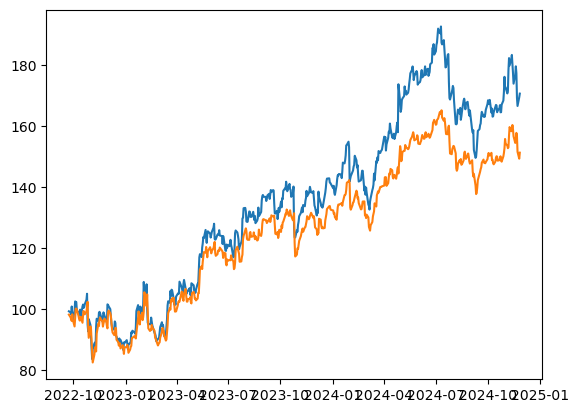

In [69]:
prediction_plot(model_pred)

In [78]:
# function to plot all model prediction with real data 
def prediction_plot_all(predictions_rnn, prediction_gru, predictions_lstm, model):
  fig, ax = plt.subplots()
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(predictions_rnn[:, 0].reshape(-1, 1)), label="RNN")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(predictions_lstm[:, 0].reshape(-1, 1)), label="LSTM")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(prediction_gru[:, 0].reshape(-1, 1)), label="GRU")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(model[:, 0].reshape(-1, 1)), label="GRU AND LSTM")
  ax.legend()

### plot all model prediction

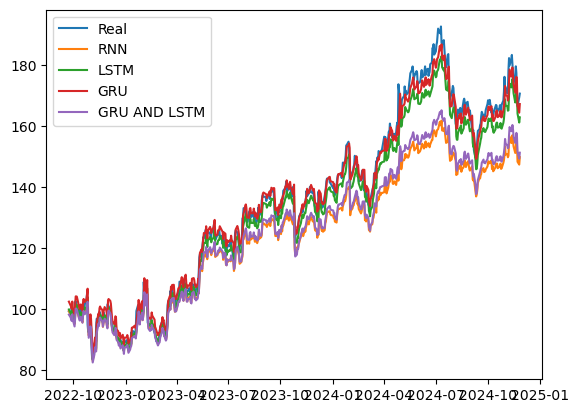

In [79]:
prediction_plot_all(rnn_pred, gru_pred, lstm_pred, model_pred)